In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#import catboost as cb
import lightgbm
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Podsumowanie
***

__Kluczowe problemy:__
* wielowymiarowość: duza ilość zmiennych dyskretnych wśród, których jest wiele grup, które niekoniecznie mają wpływ na badanną zmienną, a znacząco zwiększają złozoność modelu

* wysoka asymetria rozkładu badanej zmiennej oraz niezbalansowanie. zdecydowana większość obserwacji mieści się w przedziale 0-6 000, gdy outliery sięgają ponad 100 000

* z uwagi na fakt, że data_rejestracji oraz data_ostatniego_zamowienia mają niewielki wpływ na zmienną objaśnianą - jedynie 2 zmienne ciągłe, które nie zawsze cechują się na tyle dużym zróżnicowaniem, aby w pełni wyjaśnić zmienność i zróżnicowanie targetu

***

__Podjęte działania w celu rozwiązania problemów:__
* dodanie nowych zmiennych, ktore maja na celu pomóc w wychwyceniu zróżnicowania pomiędzy grupami w zmiennych kategorycznych lub uchwycić interakcje pomiędzy zmiennymi

* próba automatycznej redukcji liczby grup wśród zmiennych o wysokiej liczbie kategorii za pomocą grupowania kmeans - każda kategoria była charakteryzowana za pomocą charakterystyk ich rozkładu (miar położenia/zróżnicowania/asymetrii) i na tej podstawie grupowana.
liczba grup ustalona została dla każdej zmiennej za pomocą silhoulette score - miary oceniającej jak każda obserwacja (w tym przypadku kategoria) jest dobrze dopasowana do swojego klastra w porównaniu do innych klastrów.

* wypróbowano 2 modele: XGBoost i LightGBM. prawdopodobnie dobrym wyborem byłby także catboost (dobrze radzi sobie ze zmiennymi dyskretnymi).
XGBoost gorzej radzi sobie z prognozowaniem outlierow (3 pierwsze iteracje CV), natomiast LGB lepiej uogólnia całą populację.  Kwestia tego jak ważna jest to, aby mniej mylić się w przypadku outlierów, przy których i tak błąd jest już spory i dokładna predykcja jest ciężka, czy lepiej skupić się na dokładnym przewidywaniu wartości, które stanowią 80-90% zbioru.
LightGBM uzyskuje podobne wyniki (biorąc pod uwagę całą populację co niekonieczne musi być dobre) przy nieporównywalnie mniejszymi czasie spędzonym na dostrajanie hiperparametrów - więcej czasu zainwestowane dałoby najprawdopodobniej najlepszy rezultat biorąc pod uwagę stostunek czas/wynik

* nie zdecydowałem się na usuwanie obserwacji odstających z tego powodu, że podjęcie decyzji o tym wymaga głębszej znajomości specyfiki problemi (w mojej ocenie) i w niektórych przypadkach ich istnienie może być nieodłączą częścią analizy

* do walidacji wykorzystano 10-krotną walidację krzyżową - z powodu znacznego niezbalansowania wydaje się być konieczny, aż 10-krotny podział, a wykorzystanie podziału na zbiór testowy/treningowy może być poprane jednyie jeśl np. zastosujemy losowanie warstowowe, gdzie zmienną warstwującą będzie np. zmienna tworzącą kategorie na podstawie wpadania w konkretny percentyl, tak aby uchwycić odpowiednią ilość obserwacji odstających. 
Jednak najprawdopodobniej dałoby to ten sam wynik co 10-krotna walidacja krzyżowa.

***

__Mozliwości poglebienia analizy i dalszego rozwoju:__
* przeprowadzenie szczegółowej analizy wszystkich kategorii wśród zmiennych dyskretnych za pomocą np. analizy wariancji (anova) i w ten sposób zredukować liczbę klas, bądź ręcznie analizować rozkłady i charakterystyki rozkładu zmiennych pomiędzy grupami w każdej zmiennej w celu redukcji klas (czasochłonne podejście, które częściowo zostało wdrożone - na przykładzie zmiennej 'liczba_pracownikow'. )

* sprawdzenie, czy obecne dane są w jakimkolwiek przypadku w stanie wyjaśnić wartości odstające - jeśli nie, to może lepiej byłoby całkowicie zrezygnować z próby ich predykcji (wykluczyć z próby) i zaakceptować fakt, że ich występowanie jest na tyle losowe, że próba ich uwzględnienia jedynie pogarsza wyniki wśród zdecydowanej większości populacji. Do poradzenia sobie z wartościami odstającymi można stworzyć osobny model klasyfikacji zwracający prawdopodobieństwo bycia 'gwiazda' lub wybrać jakąś metodę z zakresu statystyki odpornej, która będzie eleminowała outliery

* zastosowanie stackingu regresji liniowej, bądź innego, bardziej klasycznego modelu jak GAM/liniowe modele mieszane i dodanie nowych zmiennych z interakcją pomiędzy wynikiem regresji liniowej (czasochłonne podejście, ponieważ wymagałoby przeprojektowania systemu predykcji i walidacji krzyżowej tak, aby predykcja ze stackowanego modelu przypadkiem nie dostarczała nieznanych informacji) 


In [51]:
df = pd.read_csv('dane_rekrutacja.csv', delimiter=';', encoding='latin')
df.drop(columns='id', inplace=True)
df.insert(0 ,'target', df['target_wartosc_sprzedazy'])
df.drop(columns='target_wartosc_sprzedazy', inplace=True)
df['liczba_pracownikow'] = df['liczba_pracownikow'].fillna('brak_inf')
df['jakosc_strony_www'] = df['jakosc_strony_www'].fillna(0)
df

,target,nazwa_wojewodztwa,kod_rynku,kod_branzy,liczba_pracownikow,zrodlo_rejestr,data_rejestracji,data_ostatnie_zamowienie,obecnosc_w_internecie,jakosc_strony_www,allegro,srednia_liczba_odslon,hurt
0,165550,l¹skie,TYW,10001,21-50 osób,KRS,2002-01-01,2020-06-30,e-commerce,98.0,TAK,8 278,1
1,118759,ma³opolskie,NSW,98,6-10 osób,KRS,2004-06-30,2020-08-28,ma stronê www,100.0,NIE,5 938,0
2,115420,wielkopolskie,POW,10001,101-250 osób,KRS,2003-10-17,2020-10-08,ma stronê www,79.0,NIE,11 542,1
3,108000,l¹skie,TYW,755,2-5 osób,CEIDG,1994-02-25,2020-07-31,ma stronê www,70.0,TAK,5 400,0
4,104111,zachodniopomorskie,SZW,755,6-10 osób,KRS,2015-08-31,2020-03-05,ma stronê www,79.0,NIE,5 206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,400,mazowieckie,WAW,652,1 osoba,CEIDG,2011-10-06,2020-09-25,ma stronê www,70.0,NIE,20,0
12241,400,³ódzkie,SRW,1574,2-5 osób,CEIDG,2011-07-19,2019-06-07,nie ma strony www,0.0,NIE,NaN,0
12242,400,kujawsko-pomorskie,BDW,10001,brak_inf,CEIDG,2008-02-01,2020-06-30,ma stronê www,58.0,NIE,20,0
12243,400,wielkopolskie,KNW,1574,1 osoba,CEIDG,2008-06-01,2018-04-04,ma stronê www,49.0,NIE,8,0


Przetwarzanie/data cleaning

In [52]:
# poprawa nazw wojewodztw
zle_nazwy = df['nazwa_wojewodztwa'].unique()
wojewodztwa = ['slaskie', 'malopolskie', 'wielkopolskie', 'zachodniopomorskie', 'mazowieckie', 'dolnoslaskie', 'lubelskie', 'swietokrzyskie', 'pomorskie', 'lodzkie', 'lubuskie', 'kujawsko-pomorskie', 'podlaskie', 'warminsko-mazurskie', 'opolskie', 'podkarpackie']
dict_woj = dict(zip(zle_nazwy, wojewodztwa))
df['nazwa_wojewodztwa'] = df['nazwa_wojewodztwa'].map(dict_woj)

df['liczba_pracownikow'] = df['liczba_pracownikow'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df['obecnosc_w_internecie'] = df['obecnosc_w_internecie'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [53]:
# sprawdzenie kolumn/nulli
#df = df.convert_dtypes()
df['target'] = df['target'].str.replace(',', '.').astype('float')
df['srednia_liczba_odslon'] = df['srednia_liczba_odslon'].str.replace(' ', '').astype('float')
#df['srednia_liczba_odslon'] = df['srednia_liczba_odslon'].fillna(0)
df['data_rejestracji'] = (pd.to_datetime('2023-01-01') - pd.to_datetime(df['data_rejestracji'])).dt.days
df['data_ostatnie_zamowienie'] = (pd.to_datetime('2023-01-01') - pd.to_datetime(df['data_ostatnie_zamowienie'])).dt.days
df['kod_branzy'] = df['kod_branzy'].astype('string')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    12245 non-null  float64
 1   nazwa_wojewodztwa         12245 non-null  object 
 2   kod_rynku                 12245 non-null  object 
 3   kod_branzy                12245 non-null  string 
 4   liczba_pracownikow        12245 non-null  object 
 5   zrodlo_rejestr            12245 non-null  object 
 6   data_rejestracji          12245 non-null  int64  
 7   data_ostatnie_zamowienie  12245 non-null  int64  
 8   obecnosc_w_internecie     12245 non-null  object 
 9   jakosc_strony_www         12245 non-null  float64
 10  allegro                   12245 non-null  object 
 11  srednia_liczba_odslon     9344 non-null   float64
 12  hurt                      12245 non-null  int64  
dtypes: float64(3), int64(3), object(6), string(1)
memory usage: 1

### EDA

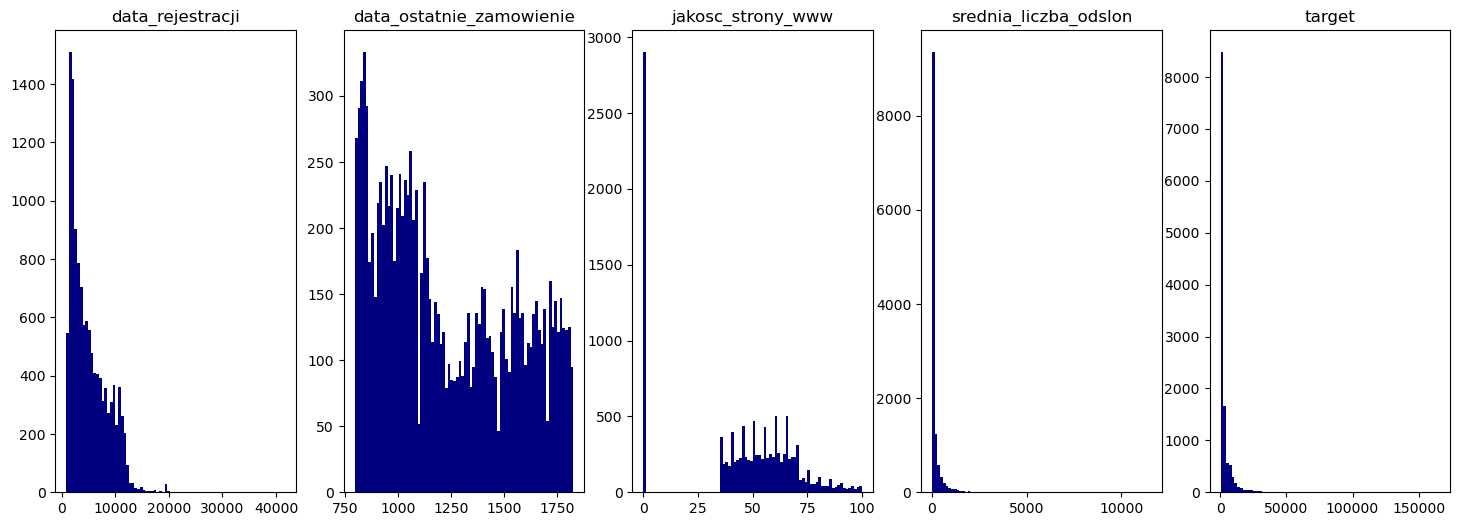

In [33]:
var_cont = ['data_rejestracji', 'data_ostatnie_zamowienie', 'jakosc_strony_www', 'srednia_liczba_odslon', 'target']
# rozklady zmiennych ciaglych

fig, axs = plt.subplots(1,5,figsize=(18,6))

for i, zmienna in enumerate(var_cont):
    axs[i].hist(df[zmienna], bins=80, color='navy', )
    axs[i].set_title(zmienna)

plt.show()

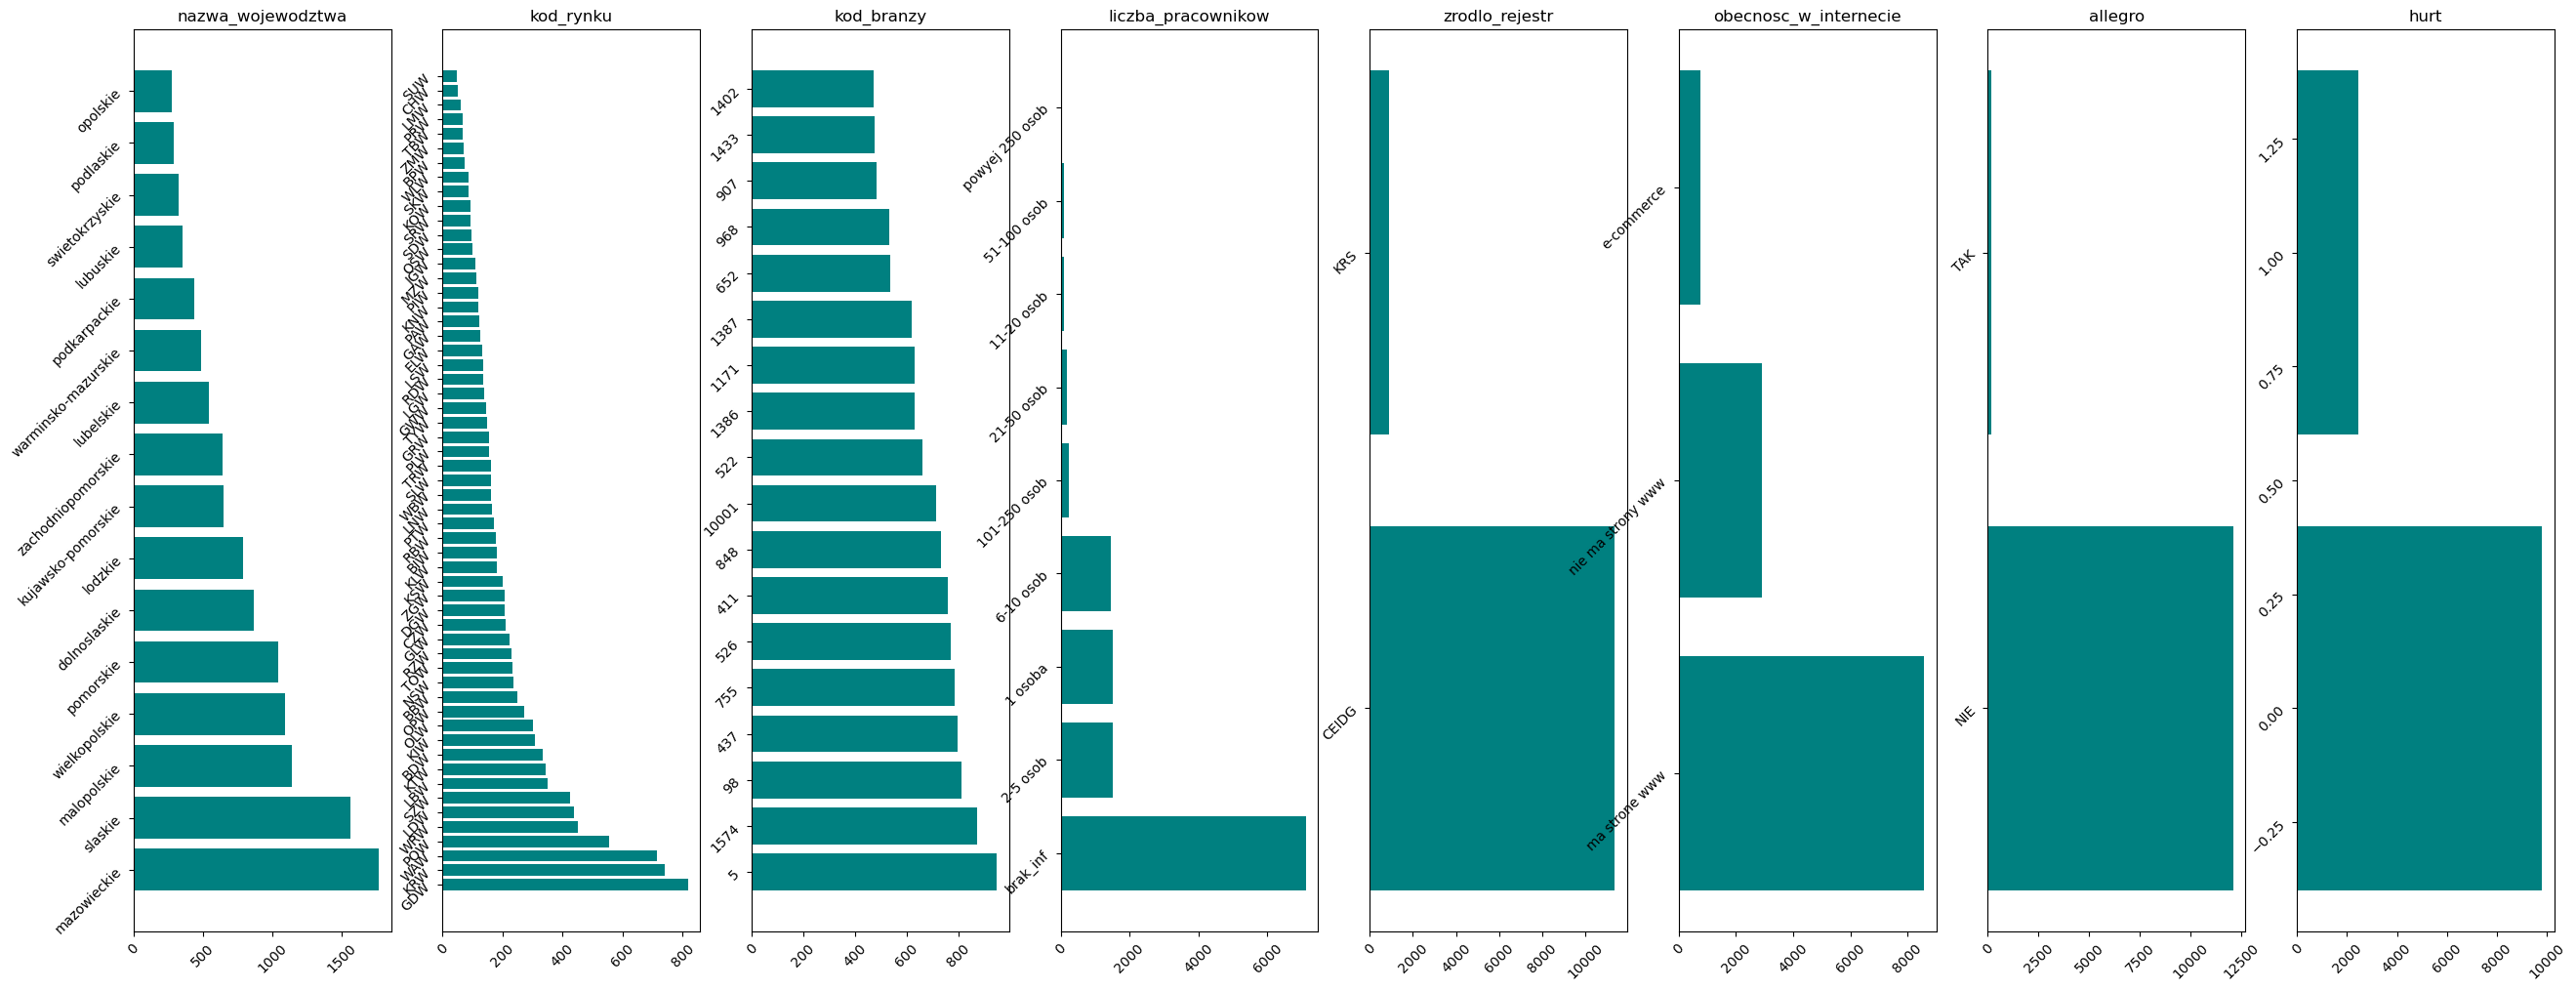

In [34]:
var_cat = df.columns[~df.columns.isin(var_cont)].tolist()

fig, axs = plt.subplots(1,len(var_cat) , figsize=(32,12))

for i, var in enumerate(var_cat):
    temp_df = df[var].value_counts().to_frame()
    axs[i].barh(temp_df.index, temp_df.iloc[:,0], color='teal')
    axs[i].set_title(var)
    axs[i].tick_params(rotation=45)
    
plt.show()

Interakcje pomiedzy zmiennymi ciaglymi

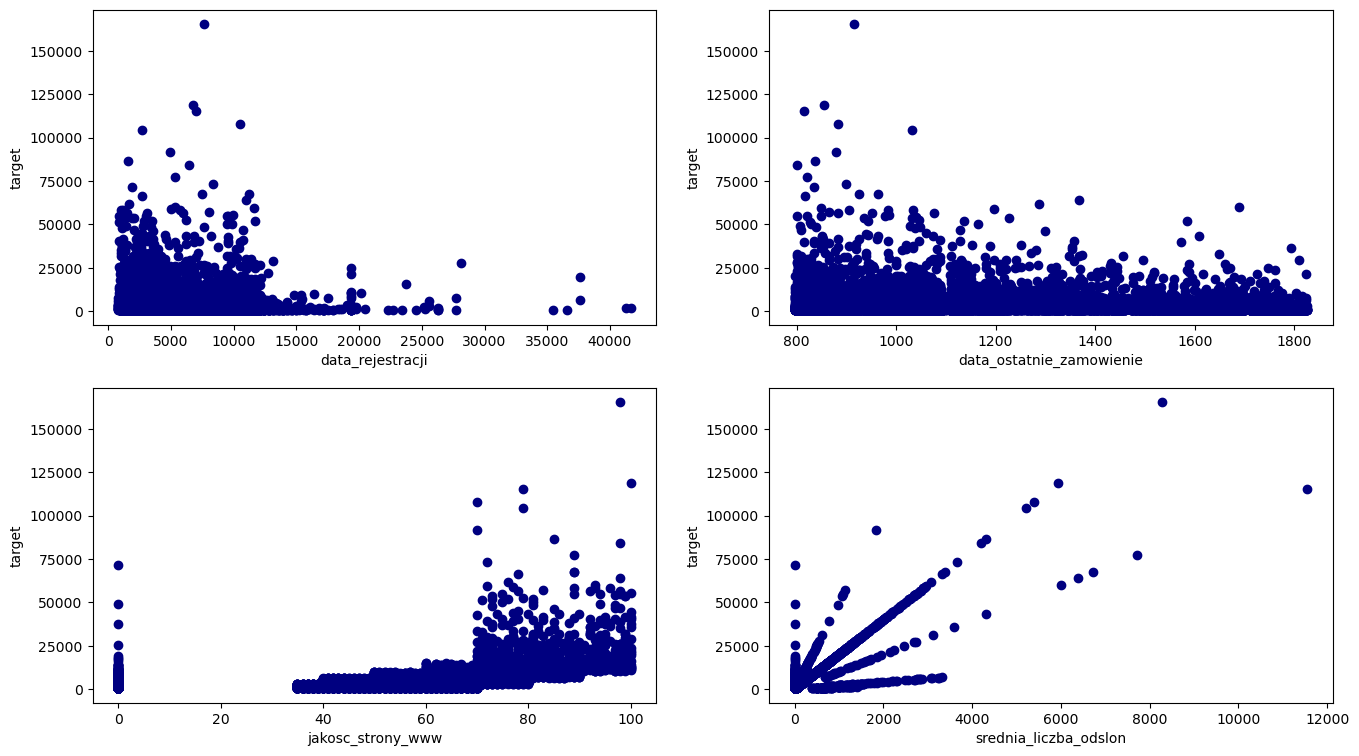

In [35]:
ncol=2
nrow=2
fig, axs = plt.subplots(ncol,nrow,figsize=(16,9))
i=0
for c in range(ncol):
    for r in range(nrow):
        axs[c,r].scatter(df[var_cont[i]], df[var_cont[-1]], color='navy')
        axs[c,r].set_xlabel(var_cont[i])
        axs[c,r].set_ylabel(var_cont[-1])
        i+=1
plt.show()

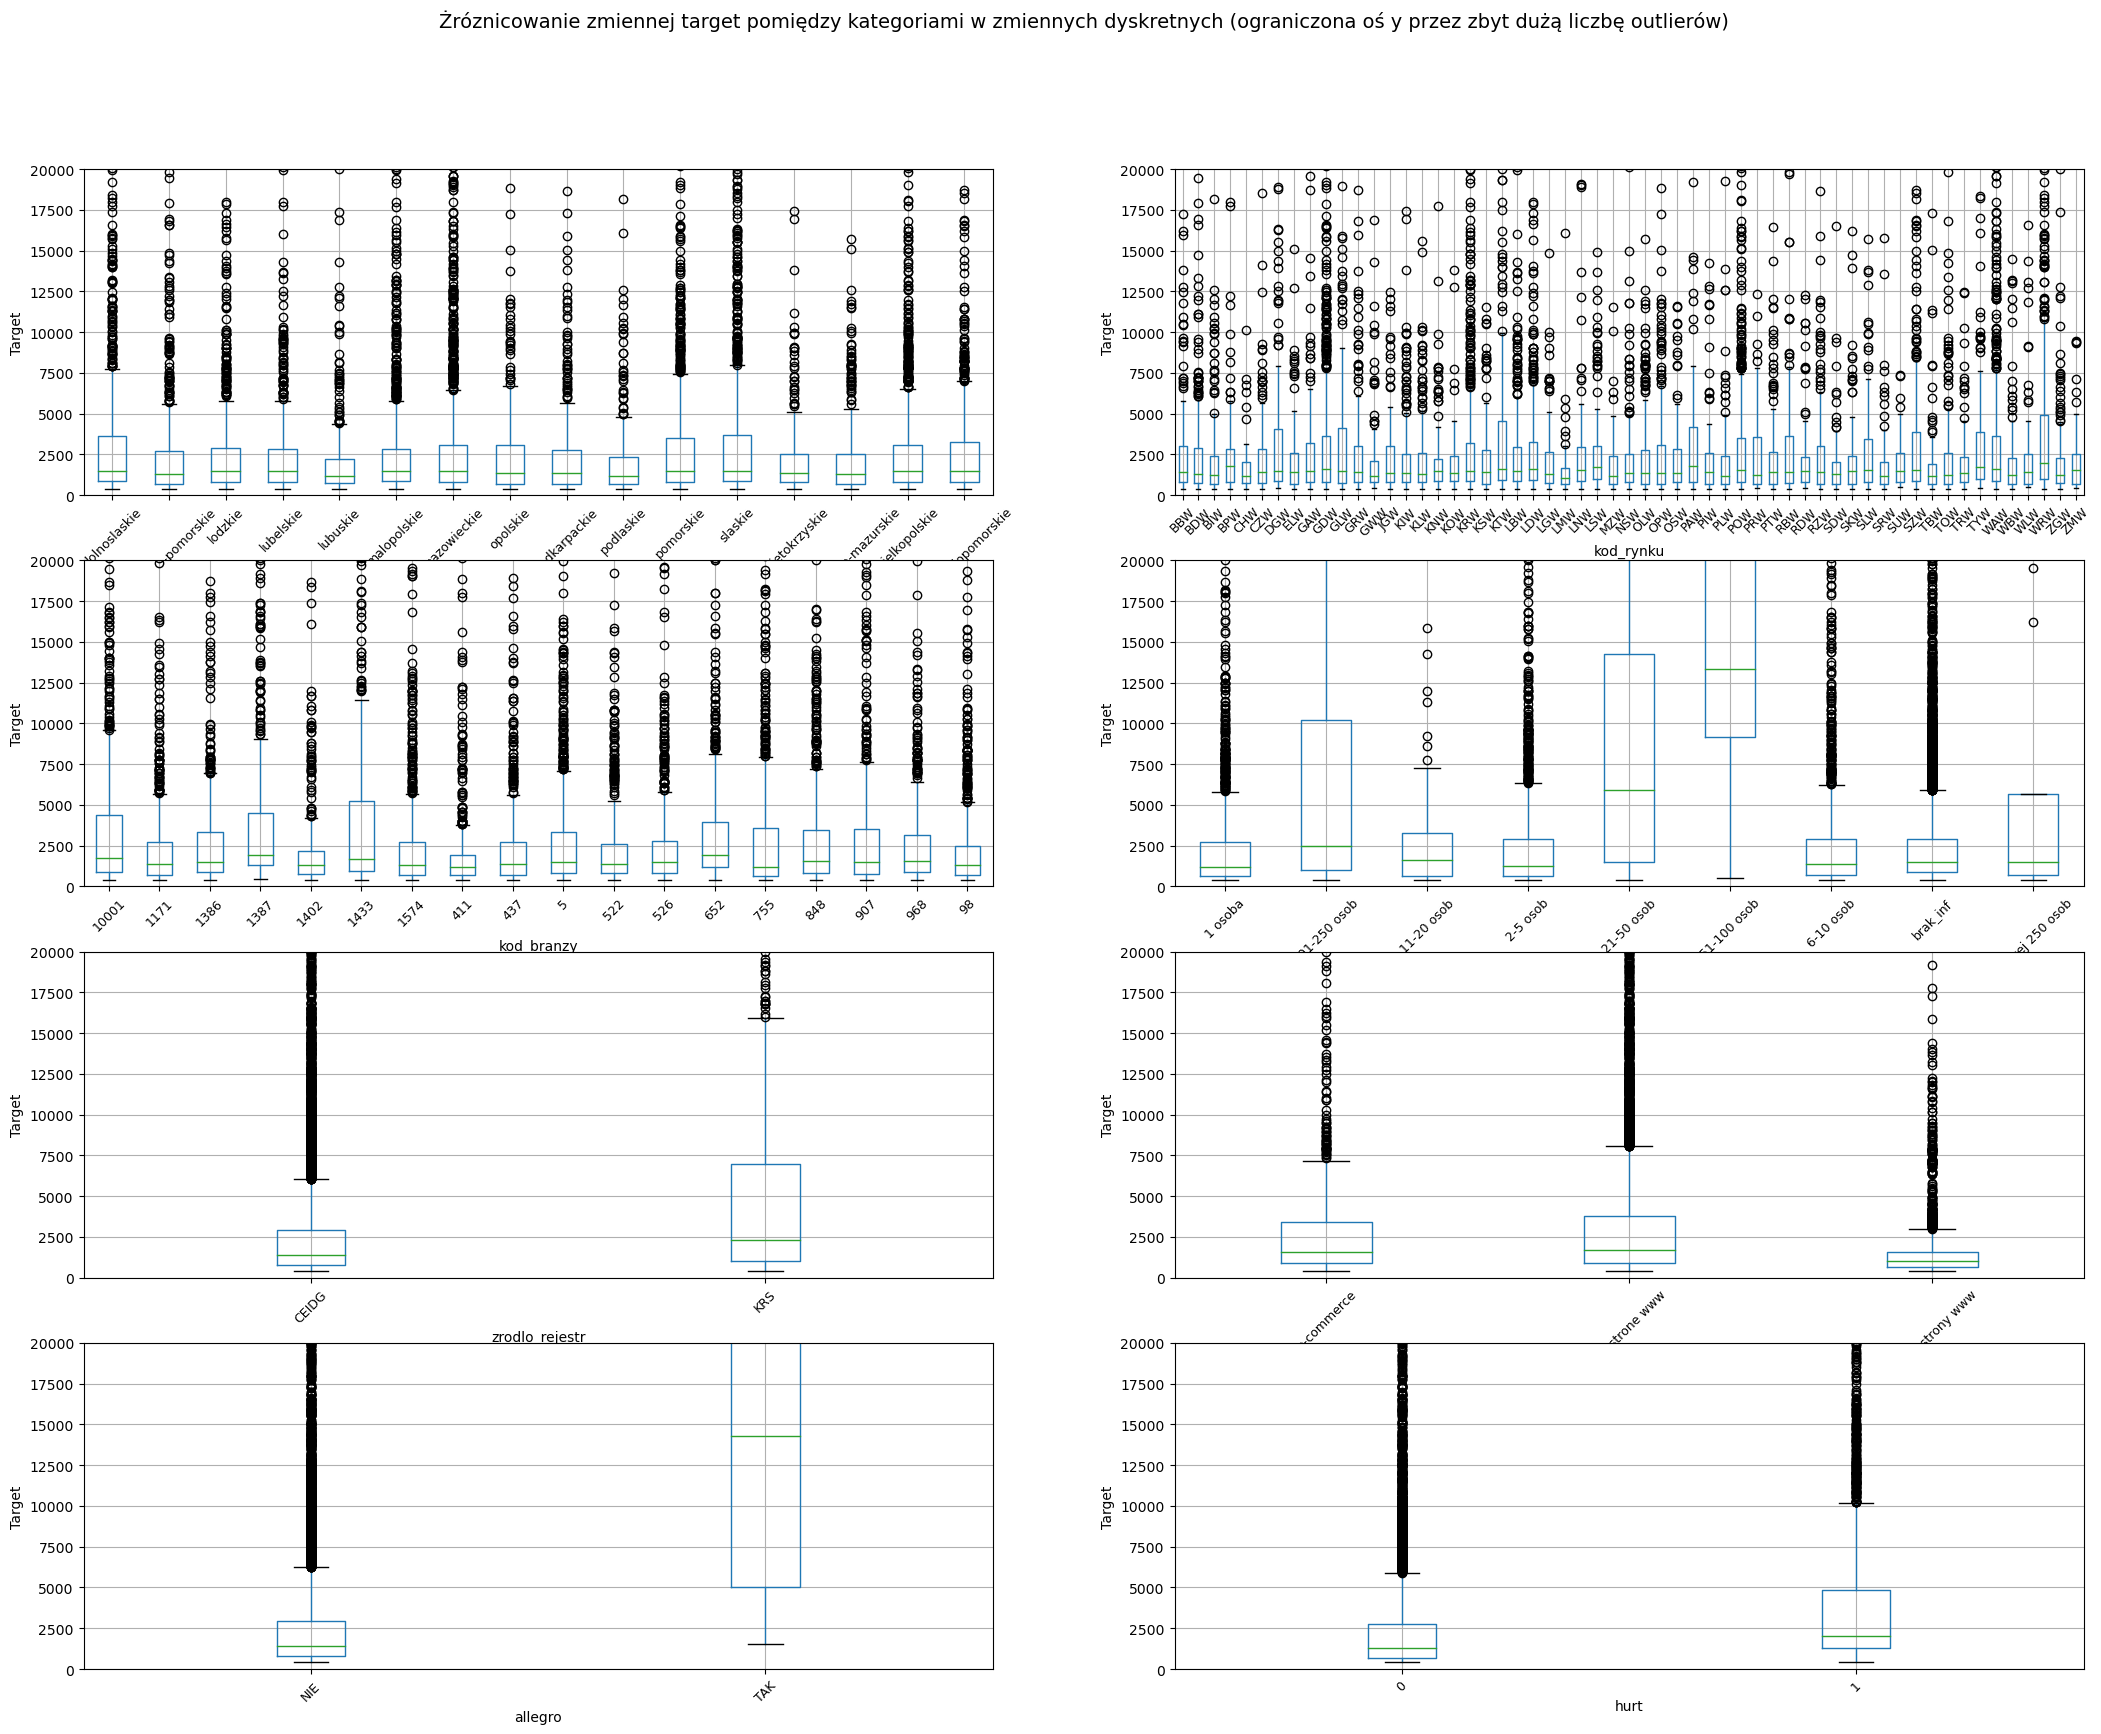

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten() 

for i, col in enumerate(var_cat):
    bp = df.boxplot(column='target', by=col, ax=axes[i])
    bp.set_xticklabels(bp.get_xticklabels(), rotation=45, fontsize=9)
    axes[i].set_title('')#f"Target by {col}", fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Target', fontsize=10)
    axes[i].set_ylim([0, 2E4])

fig.suptitle('Żróznicowanie zmiennej target pomiędzy kategoriami w zmiennych dyskretnych (ograniczona oś y przez zbyt dużą liczbę outlierów)', fontsize=14)
plt.show()

### Feature engineering

In [54]:
df_org = df.copy()

In [55]:
df = df_org.copy()
df.drop(columns=['zrodlo_rejestr'], inplace=True)

In [56]:
liczba_pracownikow_map = {
    '1 osoba': '1-10 osob',
    '2-5 osob': '1-10 osob',
    '6-10 osob': '1-10 osob',
    '21-50 osob': '21-50 osob',
    '101-250 osob': '101-250 osob',
    '51-100 osob': '51-100 osob',
    'brak_inf': 'brak_inf',
    '11-20 osob': '11-20 osob',
    'powyej 250 osob': 'powyej 250 osob'
}

In [57]:
# Przesuniete do wyznaczenia juz na podstawie zredukowanych grup (po clusteringu)

# df['liczba_pracownikow'] = df['liczba_pracownikow'].map(liczba_pracownikow_map)
# df['obecnosc_w_internecie'] = df['obecnosc_w_internecie'].map({'e-commerce': 'istnieje', 'ma strone www': 'istnieje', 'nie ma strony www': 'nie'})

# for var in ['nazwa_wojewodztwa', 'kod_rynku', 'kod_branzy', 'liczba_pracownikow']:
#     # podstawowe statystyki rozkladu
#     df[f'mean_{var}'] = df.groupby(var)['target'].transform('mean')
#     df[f'var_{var}'] = df.groupby(var)['target'].transform('var')
#     #df[f'iqr_{var}'] = df.groupby(var)['target'].transform(lambda x: x.quantile(0.75) - x.quantile(0.25))
#     df[f'skew_{var}'] = df.groupby(var)['target'].transform('skew')
    
#     # informacje o liczbie outlierow
#     q_9 = df['target'].quantile(0.9)
#     q_75 = df['target'].quantile(0.75)
#     #df[f'q9_{var}'] = df.groupby(var)['target'].transform(lambda x: (x > q_9).sum())
#     #df[f'q75_{var}'] = df.groupby(var)['target'].transform(lambda x: (x > q_75).sum())
    
# df['jakosc_srednia'] = df['jakosc_strony_www'] * df['srednia_liczba_odslon'] 
# df['var_kod_jakosc'] = df['var_kod_rynku'] * df['jakosc_strony_www'] 
# # df['mean_rynek_branza'] = df['mean_kod_branzy'] * df['mean_kod_rynku']



In [58]:
# redukcja ilości grup za pomoca kmeans

# testowanie liczby grup
zmienna = 'nazwa_wojewodztwa'
to_cluster =  df.groupby(zmienna)['target'].agg(['mean', 'std', 'skew']).sort_values(by=['mean', 'std'])
scaler = StandardScaler()
scaler.fit(to_cluster)
to_cluster_std = scaler.transform(to_cluster)
to_cluster_std = pd.DataFrame(to_cluster_std, columns=to_cluster.columns)

for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    preds = km.fit_predict(to_cluster_std)
    score = silhouette_score(to_cluster_std, preds)
    print("Dla klastra {} silhouette score {})".format(n_clusters, score))

# nazwa_wojewodztwa - 2, bez skew: 2
# kod_rynku - 4, bez skew: 3
# kod_branzy - 3, bez skew: 2

Dla klastra 2 silhouette score 0.42175903263631087)
Dla klastra 3 silhouette score 0.37123023073710726)
Dla klastra 4 silhouette score 0.3888936719071385)
Dla klastra 5 silhouette score 0.4149643481847761)
Dla klastra 6 silhouette score 0.3950132046212855)
Dla klastra 7 silhouette score 0.3456240933417774)
Dla klastra 8 silhouette score 0.32941675876253024)


In [59]:
# mapping klastrow
klastry = {'nazwa_wojewodztwa': 2,
           'kod_rynku': 4,
           'kod_branzy': 3}

for zmienna in klastry:
    to_cluster =  df.groupby(zmienna)['target'].agg(['mean', 'std', 'skew']).sort_values(by=['mean', 'std'])
    scaler = StandardScaler()
    scaler.fit(to_cluster)
    to_cluster_std = scaler.transform(to_cluster)
    to_cluster_std = pd.DataFrame(to_cluster_std, columns=to_cluster.columns)
    km = KMeans(n_clusters=klastry[zmienna])
    preds = km.fit_predict(to_cluster_std)
    df[zmienna] = pd.merge(df, pd.DataFrame({zmienna: to_cluster.index, 'new': preds}), on=zmienna, how='left')['new'].astype('object')

In [60]:
df['liczba_pracownikow'] = df['liczba_pracownikow'].map(liczba_pracownikow_map)
df['obecnosc_w_internecie'] = df['obecnosc_w_internecie'].map({'e-commerce': 'istnieje', 'ma strone www': 'istnieje', 'nie ma strony www': 'nie'})

for var in ['nazwa_wojewodztwa', 'kod_rynku', 'kod_branzy', 'liczba_pracownikow']:
    # podstawowe statystyki rozkladu
    df[f'mean_{var}'] = df.groupby(var)['target'].transform('mean')
    df[f'var_{var}'] = df.groupby(var)['target'].transform('var')
    #df[f'iqr_{var}'] = df.groupby(var)['target'].transform(lambda x: x.quantile(0.75) - x.quantile(0.25))
    df[f'skew_{var}'] = df.groupby(var)['target'].transform('skew')
    
    # informacje o liczbie outlierow
    q_9 = df['target'].quantile(0.9)
    q_75 = df['target'].quantile(0.75)
    #df[f'q9_{var}'] = df.groupby(var)['target'].transform(lambda x: (x > q_9).sum())
    #df[f'q75_{var}'] = df.groupby(var)['target'].transform(lambda x: (x > q_75).sum())
    
df['jakosc_srednia'] = df['jakosc_strony_www'] * df['srednia_liczba_odslon'] 
df['var_kod_jakosc'] = df['var_kod_rynku'] * df['jakosc_strony_www'] 
# df['mean_rynek_branza'] = df['mean_kod_branzy'] * df['mean_kod_rynku']

OneHotEncoding

In [322]:
#df_onehot = df.drop(var_cat, axis=1) 

In [61]:
onehot = OneHotEncoder(sparse_output=False)

categories = df.select_dtypes(include = ['object', 'string'])
to_encode = categories#.drop(['nazwa_wojewodztwa', 'kod_rynku'],axis=1)
onehot_encoded = onehot.fit_transform(to_encode)
df_encoded = pd.DataFrame(onehot_encoded, columns=onehot.get_feature_names_out()).astype('int8')

df_onehot = pd.concat([df, df_encoded], axis=1)

df_onehot = df_onehot.drop(categories.columns, axis=1) #to_encode.columns, axis=1)

df_onehot.reset_index(drop=True)
print(f'shape: {df_onehot.shape}')
df_onehot.head(2)

shape: (12245, 40)


,target,data_rejestracji,data_ostatnie_zamowienie,jakosc_strony_www,srednia_liczba_odslon,hurt,mean_nazwa_wojewodztwa,var_nazwa_wojewodztwa,skew_nazwa_wojewodztwa,mean_kod_rynku,...,liczba_pracownikow_101-250 osob,liczba_pracownikow_11-20 osob,liczba_pracownikow_21-50 osob,liczba_pracownikow_51-100 osob,liczba_pracownikow_brak_inf,liczba_pracownikow_powyej 250 osob,obecnosc_w_internecie_istnieje,obecnosc_w_internecie_nie,allegro_NIE,allegro_TAK
0,165550.0,7670,915,98.0,8278.0,1,3553.431705,4.823805e+07,7.236079,6226.034899,...,0,0,1,0,0,0,1,0,0,1
1,118759.0,6759,856,100.0,5938.0,0,3553.431705,4.823805e+07,7.236079,3050.464642,...,0,0,0,0,0,0,1,0,1,0


Numerical encoding

In [16]:
# df_num = df.copy()

# for var in categories:
#     if var in df_num.columns:
#         df_num[var] = df_num[var].astype('category').cat.codes
# df_num.head(3)

,target,nazwa_wojewodztwa,kod_rynku,kod_branzy,liczba_pracownikow,data_rejestracji,data_ostatnie_zamowienie,obecnosc_w_internecie,jakosc_strony_www,allegro,...,q9_kod_branzy,q75_kod_branzy,mean_liczba_pracownikow,var_liczba_pracownikow,iqr_liczba_pracownikow,skew_liczba_pracownikow,q9_liczba_pracownikow,q75_liczba_pracownikow,jakosc_srednia,var_kod_jakosc
0,165550.0,11,50,0,3,7670,915,0,98.0,1,...,106,238,10969.412903,2.662894e+08,12774.0,5.292264,88,113,811244.0,2.053232e+11
1,118759.0,5,28,17,0,6759,856,0,100.0,0,...,60,167,3099.204617,4.110635e+07,2217.5,7.766747,406,1037,593800.0,8.549584e+10
2,115420.0,14,35,0,1,7016,815,0,79.0,0,...,106,238,8727.627600,2.148821e+08,9215.5,3.441820,74,112,911818.0,3.645416e+10


### XGBoost

In [62]:
selected_df = df_onehot.copy()
x = selected_df.iloc[:,1:]
y = selected_df.iloc[:,0]
print(x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

(12245, 39)


In [63]:
print('XGBoost')
params = {'alpha': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

xgb = xgboost.XGBRegressor(max_depth=5, n_estimators=150, learning_rate=0.01)

xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
print('Test Error:',mean_squared_error(y_test, pred)**0.5)
print('Test R2:', r2_score(y_test, pred))

cv = cross_validate(xgb, x, y, cv=10, scoring = ['neg_mean_squared_error'], n_jobs=5)

results = pd.DataFrame(cv)
results['rmse'] = np.sqrt(np.abs(results['test_neg_mean_squared_error']))
print('10-CV Error:',results['rmse'].mean())

results

XGBoost
Test Error: 2412.5370425441356
Test R2: 0.8101267208145745
10-CV Error: 2877.0979779026684


,fit_time,score_time,test_neg_mean_squared_error,rmse
0,7.447428,0.013828,-3.657407e+08,19124.347108
1,7.378036,0.015597,-1.857029e+07,4309.325836
2,7.378825,0.014059,-3.192376e+06,1786.722056
3,7.425524,0.013051,-8.167872e+05,903.762776
4,7.446072,0.012982,-2.810222e+05,530.115302
5,7.269427,0.015093,-8.610432e+04,293.435385
6,7.277729,0.015923,-4.886195e+04,221.047387
7,7.275417,0.012783,-2.644265e+05,514.224211
8,7.293605,0.011024,-1.510874e+05,388.699609
9,7.255926,0.012647,-4.890206e+05,699.300110


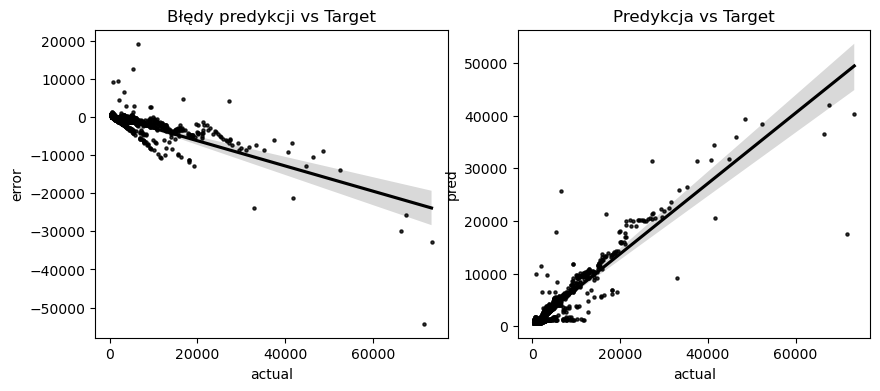

In [64]:
df_errors = pd.DataFrame({'pred': pred, 'actual': y_test})
df_errors['error'] = df_errors['pred'] - df_errors['actual']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.regplot(x="actual", y="error", data=df_errors, ax=axes[0], color='black', scatter_kws={"s": 5})
axes[0].set_title("Błędy predykcji vs Target")

sns.regplot(x="actual", y="pred", data=df_errors, ax=axes[1], color='black', scatter_kws={"s": 5})
axes[1].set_title("Predykcja vs Target")
plt.show()

In [ ]:
a

In [293]:
params_to_try = {
    'max_depth': [4,5,6,7,8],
    'n_estimators': [100,150,200,250,300,400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'lambda': [1,1.5,2],
    'alpha': [0,0.5,1]
}

grid_obj = GridSearchCV(
    estimator = xgboost.XGBRegressor(),
    param_grid = params_to_try,
    scoring = 'neg_mean_squared_error',
    n_jobs=5,
    verbose=13,
    cv=5
)

grid_obj.fit(x, y)
grid_obj.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV 3/5; 1/360] START alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100
[CV 1/5; 1/360] START alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100
[CV 2/5; 1/360] START alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100
[CV 4/5; 1/360] START alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100
[CV 5/5; 1/360] START alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100
[CV 1/5; 1/360] END alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100;, score=-220337411.936 total time=  11.6s
[CV 2/5; 1/360] END alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100;, score=-1753507.814 total time=  11.6s
[CV 4/5; 1/360] END alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100;, score=-110337.247 total time=  11.6s
[CV 3/5; 1/360] END alpha=0, learning_rate=0.01, max_depth=4, n_estimators=100;, score=-207305.376 total time=  11.6s
[CV 1/5; 2/360] START alpha=0, learning_rate=0.01, max_

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [295]:
grid_obj.best_params_

{'alpha': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

<BarContainer object of 39 artists>

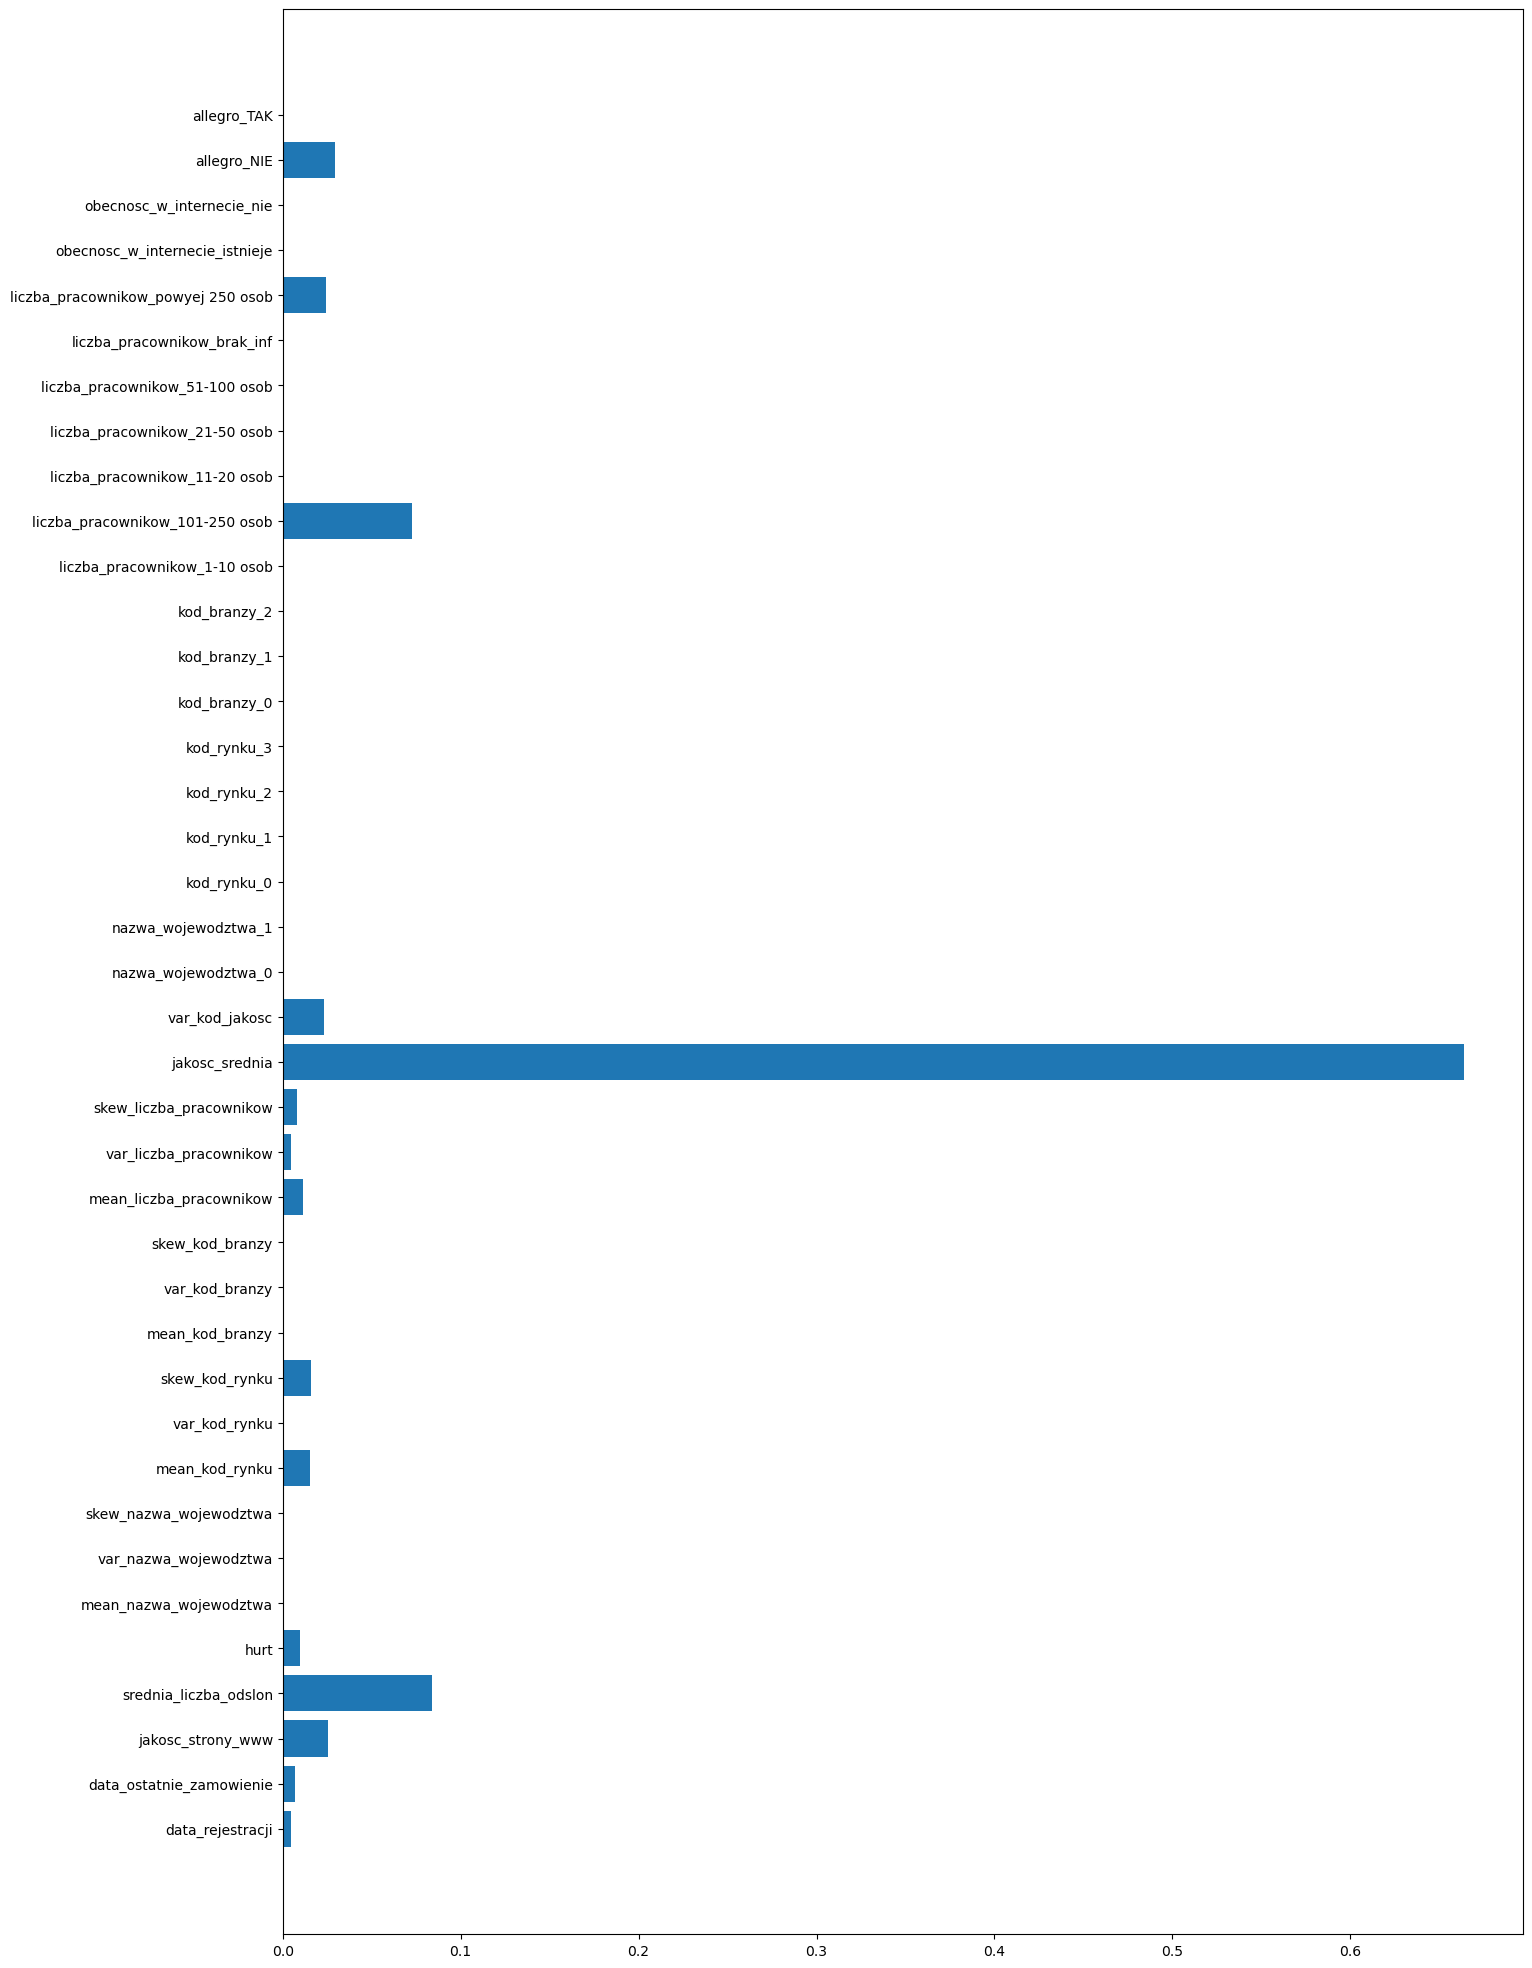

In [260]:
plt.figure(figsize=(16,25))
plt.barh(xgb.feature_names_in_, xgb.feature_importances_)

### LIGHTGBM

In [65]:
print('LigthGBM')
{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 10,
 'n_estimators': 200}

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 10,
 'n_estimators': 250}

lgbm = lightgbm.LGBMRegressor(max_depth=3, n_estimators=250, min_child_samples=10, learning_rate=0.1, n_jobs=5)

lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
print('Test Error:',mean_squared_error(y_test, pred)**0.5)
print('Test R2:', r2_score(y_test, pred))

cv = cross_validate(lgbm, x, y, cv=10, scoring = ['neg_mean_squared_error'], n_jobs=5)

results = pd.DataFrame(cv)
results['rmse'] = np.sqrt(np.abs(results['test_neg_mean_squared_error']))
print('10-CV Error:',results['rmse'].mean())

results
# 2884 

LigthGBM
Test Error: 2279.2034960064243
Test R2: 0.8305341965223475
10-CV Error: 2875.824139602971


,fit_time,score_time,test_neg_mean_squared_error,rmse
0,1.383105,0.009714,-2.931233e+08,17120.842733
1,1.270373,0.011554,-2.125902e+07,4610.750655
2,1.280601,0.009109,-3.718446e+06,1928.327190
3,1.037078,0.013530,-1.159536e+06,1076.817353
4,0.975444,0.008475,-4.449487e+05,667.044715
5,1.432477,0.010127,-2.821743e+05,531.200810
6,1.444583,0.008733,-3.311612e+05,575.466032
7,1.292712,0.008505,-5.535935e+05,744.038669
8,1.304558,0.007693,-4.200632e+05,648.122863
9,1.247604,0.007463,-7.321033e+05,855.630375


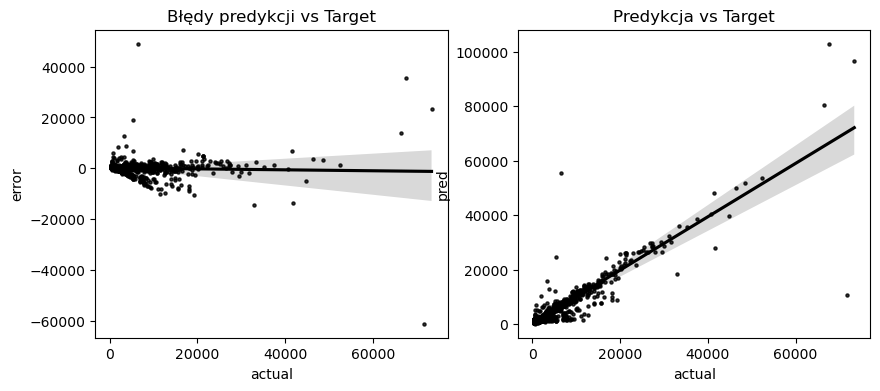

In [66]:
df_errors = pd.DataFrame({'pred': pred, 'actual': y_test})
df_errors['error'] = df_errors['pred'] - df_errors['actual']

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.regplot(x="actual", y="error", data=df_errors, ax=axes[0], color='black', scatter_kws={"s": 5})
axes[0].set_title("Błędy predykcji vs Target")

sns.regplot(x="actual", y="pred", data=df_errors, ax=axes[1], color='black', scatter_kws={"s": 5})
axes[1].set_title("Predykcja vs Target")
plt.show()

In [222]:
a # stopper, aby przypadkiem nie wykonac wszystkich komorek

NameError: name 'a' is not defined

In [196]:
params_to_try = {
    'max_depth': [3, 4,5,6, 7],
    'n_estimators': [100,150, 175,200, 225,250, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
#    'reg_alpha': [0, 0.1, 0.2],
    'min_child_samples': [10,20,30, 40]
}

grid_obj = GridSearchCV(
    estimator = lightgbm.LGBMRegressor(),
    param_grid = params_to_try,
    scoring = 'neg_mean_squared_error',
    n_jobs=6,
    verbose=1,
    cv=10
)

grid_obj.fit(x, y)

Fitting 10 folds for each of 560 candidates, totalling 5600 fits


GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=6,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5, 6, 7],
                         'min_child_samples': [10, 20, 30, 40],
                         'n_estimators': [100, 150, 175, 200, 225, 250, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [197]:
grid_obj.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 10,
 'n_estimators': 250}